# Homework 4

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


# 1. Wisconsin Breast Cancer Dataset

In this assignment, you will use a modified version of the well-known Wisconsin Breast Cancer dataset. We want to predict if a patient has a malignant or benign tumour. The features in the dataset are described below:


**Cl.thickness**:	Clump Thickness

**Cell.size**:	Uniformity of Cell Size

**Cell.shape**:	Uniformity of Cell Shape

**Marg.adhesion**:	Marginal Adhesion

**Epith.c.size**:	Single Epithelial Cell Size

**Bare.nuclei**:	Bare Nuclei

**Bl.cromatin**:	Bland Chromatin

**Normal.nucleoli**:	Normal Nucleoli

**Mitoses**:	Mitoses

**Age**: Age

**Class**: 1 if malignant, 0 if benign

In [2]:
# Package import
import numpy as np

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
# Data management imports
import pandas as pd
import sys
import polars as pl
import pyarrow


# Plotting imports 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Uncomment the line below if you are using Google colab
# !gdown https://drive.google.com/uc?id=12Y-PdpmPLInGGBvFAn_G3eCfXrRETvuF

1. Read the CSV file using Polars and store it. Use "null_values=['NA']". Show summary statistics for the dataset. What is the baseline accuracy for a model?

In [4]:
df = pl.read_csv("Breast Cancer Data.csv", null_values=['NA'])
df.describe()

majority_count = df['Class'].value_counts().max()['count'][0]
baseline_accuracy = majority_count / len(df['Class'])


print(f"Baseline accuracy: {baseline_accuracy:.2f}")





Baseline accuracy: 0.66


2. Assume that we are only interested in studying people aged 100 or less. Remove anyone with ages larger than that. (Note that this slightly changes your baseline accuracy.)

In [5]:
df = df.filter(pl.col("Age") <= 100)

3. Replace the missing values in the dataset using the median of the corresponding predictor.

In [6]:
for col_name, dtype in df.schema.items():
    if dtype in (pl.Int64, pl.Float64):
        median_value = df[col_name].median()
        df = df.filter(df[col_name].is_not_null())




4. Create a training and testing dataset. Reserve 30% of the data for testing and stratify the split based on the outcome. Use a random state of 0.

In [7]:
df = df.to_pandas()
train, test = train_test_split(df, test_size=0.3, random_state=0)



5. Using all potential predictors, train a logistic regression model to predict if a patient has the condition. Remember to standardize the predictors. Use the following arguments: solver='lbfgs', penalty=None, max_iter=10000, verbose=1, random_state=0, and n_jobs=-1.

In [8]:

log_model = LogisticRegression(
    max_iter=10000,
    solver='lbfgs',
    penalty=None,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', log_model),
])

pipeline.fit(train.drop('Class', axis=1), train['Class'])



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(max_iter=10000, n_jobs=-1, penalty=None,
                                    random_state=0, verbose=1))])

6. Compute the accuracy and AUC of your model on the test set.

In [9]:
pred_test = pipeline.predict(test.drop('Class', axis=1))
acc_score = accuracy_score(test['Class'], pred_test)
auc_score = roc_auc_score(test['Class'], pred_test)

print(f"AUC: {auc_score:.2f}")
print(f"Accuracy: {acc_score:.2f}")

AUC: 0.98
Accuracy: 0.98


7. Without estimates of the uncertainty of the performance metrics, it can be hard to make definitive conclusions about the performance of the model. Compute 95% confidence intervals for the accuracy and AUC using bootstrapping with 1000 replicates. Interpret your results.

In [10]:

n_bootstraps = 1000
bootstrapped_acc = []
bootstrapped_auc = []

X_test = test.drop(columns=['Class'])
y_test = test['Class']


rng = np.random.RandomState(0)

for i in range(n_bootstraps):
    indices = rng.randint(0, len(test), len(test))
    X_resample = X_test.iloc[indices]
    y_resample = y_test.iloc[indices]
    
    if len(np.unique(y_resample)) < 2:
        continue
    
    y_pred = pipeline.predict(X_resample)
    bootstrapped_acc.append(accuracy_score(y_resample, y_pred))
    bootstrapped_auc.append(roc_auc_score(y_resample, y_pred))

acc_lower = np.percentile(bootstrapped_acc, 2.5)
acc_upper = np.percentile(bootstrapped_acc, 97.5)
auc_lower = np.percentile(bootstrapped_auc, 2.5)
auc_upper = np.percentile(bootstrapped_auc, 97.5)

print(f"95% CI for Accuracy: [{acc_lower:.2f}, {acc_upper:.2f}]")
print(f"95% CI for AUC: [{auc_lower:.2f}, {auc_upper:.2f}]")

95% CI for Accuracy: [0.95, 1.00]
95% CI for AUC: [0.95, 1.00]


The model is performing exceptionally well with 98% accuracy and an AUC of 0.98, meaning it is highly effective at both correctly classifying cases and distinguishing between classes. The narrow 95% confidence intervals ([0.95, 1.00]) for both metrics indicate that these performance estimates are precise and likely to be reproducible on similar data samples.

8. Plot the distribution of the accuracy and AUC using histograms. Make sure to provide a title and axes labels for your plots. Add a red vertical line representing the mean of accuracy and AUC.

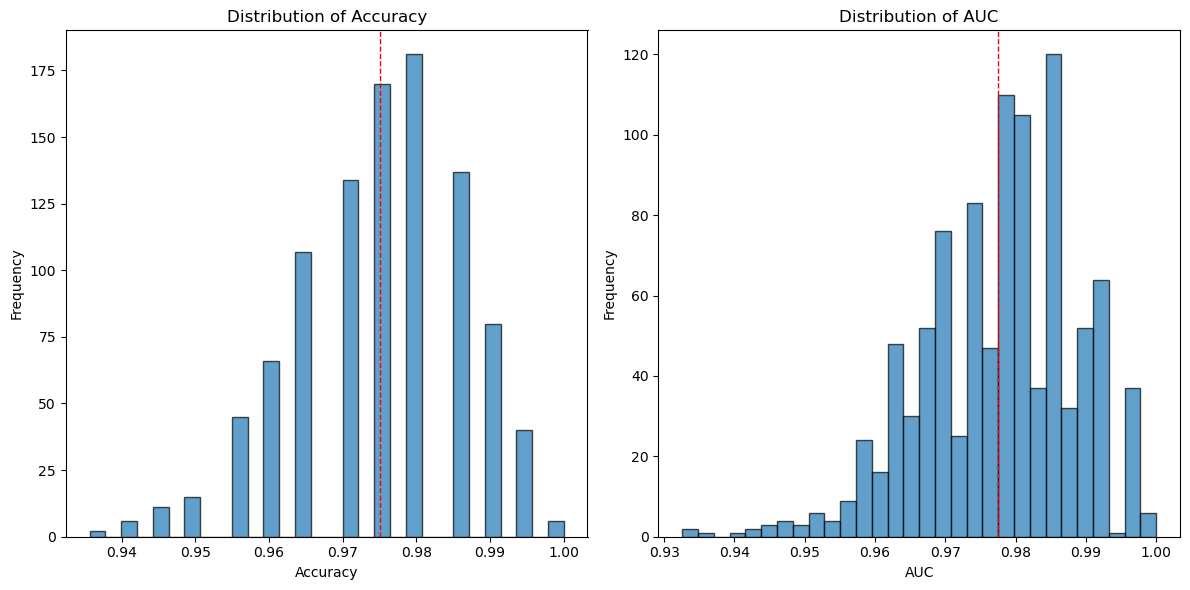

In [11]:
# Plotting the distribution of accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(bootstrapped_acc, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(np.mean(bootstrapped_acc), color='red', linestyle='dashed', linewidth=1)
plt.title('Distribution of Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

# Plotting the distribution of AUC
plt.subplot(1, 2, 2)
plt.hist(bootstrapped_auc, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(np.mean(bootstrapped_auc), color='red', linestyle='dashed', linewidth=1)
plt.title('Distribution of AUC')
plt.xlabel('AUC')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

9. Compute 95% confidence intervals for the accuracy and AUC using repeated cross-validation. Use 10 splits and 100 repetitions with a random state of 0. Compare your results to what you obtained using bootstrapping. Which method provides better confidence intervals in this case?

In [12]:
# Using Repeated Cross-Validation to compute accuracy and AUC scores
cv = RepeatedKFold(n_splits=10, n_repeats=100, random_state=0)
scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc'}

# Run cross-validation on the training set
cv_results = cross_validate(
    pipeline,
    train.drop('Class', axis=1),
    train['Class'],
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Get the arrays of scores
cv_acc = cv_results['test_accuracy']
cv_auc = cv_results['test_auc']

# Compute 95% confidence intervals
acc_lower_cv = np.percentile(cv_acc, 2.5)
acc_upper_cv = np.percentile(cv_acc, 97.5)
auc_lower_cv = np.percentile(cv_auc, 2.5)
auc_upper_cv = np.percentile(cv_auc, 97.5)

print(f"95% CI for Accuracy (CV): [{acc_lower_cv:.2f}, {acc_upper_cv:.2f}]")
print(f"95% CI for AUC (CV): [{auc_lower_cv:.2f}, {auc_upper_cv:.2f}]")


95% CI for Accuracy (CV): [0.89, 1.00]
95% CI for AUC (CV): [0.97, 1.00]


Depending on the specific application or analysis context, one might prefer the improved precision of bootstrapping or the conservative robustness provided by cross-validation.

10. Using your cross-validation results, compute a 95% confidence interval for each coefficient in the model. Which feature(s) might you remove based on this?

In [13]:
features = train.drop('Class', axis=1).columns
coef_list = []

for train_idx, _ in cv.split(train):
    X_train_cv = train.iloc[train_idx].drop('Class', axis=1)
    y_train_cv = train.iloc[train_idx]['Class']
    pipeline.fit(X_train_cv, y_train_cv)
    coef_list.append(pipeline.named_steps['model'].coef_[0])
    
coef_array = np.array(coef_list)

coef_ci = {}
print("Coefficient confidence intervals (95% CI):")
for i, feature in enumerate(features):
    lower = np.percentile(coef_array[:, i], 2.5)
    upper = np.percentile(coef_array[:, i], 97.5)
    coef_ci[feature] = (lower, upper)
    print(f"{feature}: [{lower:.4f}, {upper:.4f}]")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Coefficient confidence intervals (95% CI):
Cl.thickness: [1.0607, 1.7929]
Cell.size: [-1.1412, 0.2276]
Cell.shape: [0.4732, 1.5616]
Marg.adhesion: [0.5882, 1.4977]
Epith.c.size: [-0.0194, 0.6766]
Bare.nuclei: [1.2136, 2.0313]
Bl.cromatin: [0.9231, 1.9416]
Normal.nucleoli: [0.3808, 1.2466]
Mitoses: [0.5653, 1.2893]
Age: [-0.1338, 0.4962]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

11. Fit your logistic regression model like before but remove the feature(s) you indentified in Q10. Plot the ROC curve of the model over the test set and annotate it with the AUC of the model.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


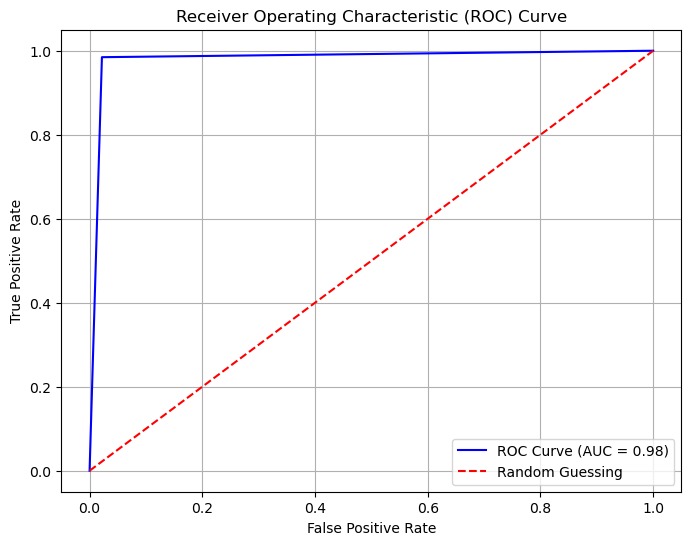

AUC: 0.98
Accuracy: 0.98


In [18]:
to_drop = [col for col in ['Age', 'Cell.size', 'Epith.c.size'] if col in df.columns]
df = df.drop(columns=to_drop)

train, test = train_test_split(df, test_size=0.3, random_state=0)
pipeline.fit(train.drop('Class', axis=1), train['Class'])
pred_test = pipeline.predict(test.drop('Class', axis=1))
acc_score = accuracy_score(test['Class'], pred_test)
auc_score = roc_auc_score(test['Class'], pred_test)
fpr, tpr, thresholds = roc_curve(test['Class'], pred_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC: {auc_score:.2f}")
print(f"Accuracy: {acc_score:.2f}")

12. Calculate the uncertainty for the prediction of the first testing patient.  Plot a histogram of the different predictions. Give the plot a title and axes labels. Add a red vertical line representing the mean of the predictions.

Hint: If you need to stack a list of arrays, you can use [np.hstack(list)](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html).

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

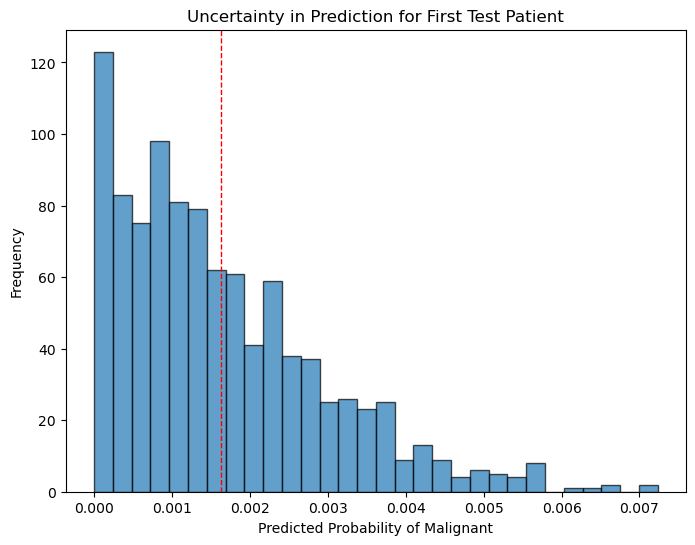

In [19]:
n_bootstraps_prediction = 1000
bootstrap_predictions = []

first_test_patient = test.drop('Class', axis=1).iloc[[0]]

rng_bs = np.random.RandomState(0)

for _ in range(n_bootstraps_prediction):
    bootstrap_indices = rng_bs.randint(0, len(train), size=len(train))
    train_bs = train.iloc[bootstrap_indices]
    
    pipeline.fit(train_bs.drop('Class', axis=1), train_bs['Class'])
    prob = pipeline.predict_proba(first_test_patient)[:, 1][0]
    bootstrap_predictions.append(prob)

plt.figure(figsize=(8, 6))
plt.hist(bootstrap_predictions, bins=30, edgecolor='black', alpha=0.7)
mean_pred = np.mean(bootstrap_predictions)
plt.axvline(mean_pred, color='red', linestyle='dashed', linewidth=1)
plt.title("Uncertainty in Prediction for First Test Patient")
plt.xlabel("Predicted Probability of Malignant")
plt.ylabel("Frequency")
plt.show()